# Electroencephalograpic classification of human non-REM sleep stages 
- Electroencephalography: EEG
- Surface measurement of post-synaptic potentials across millions of neurons
- spatial resolution: brain lobes, approximately

![Human brain lobar anatomy](img/brain_lobes_wiki.png)

EEG cap layout:
- Electrode names 
  - even numbers are over the right hemisphere
  - odd numbers are over the left hemisphere,
  - the letter 'z' (e.g. Fz, Cz, Pz) indicate an electrode over the central line (nasion to inion)
  - the letters **F, T, P, O** indicate the nearest brain lobe, **Fp** denotes fronto-polar, and **C** indicates the region around the central sulcus; the **A** electrodes are attached near the ears and are assumed to record _no_ relevant brain activity

- **Knowledge check**:
    - the precentral gyrus belongs to the __ lobe, and its function is __
    - the postcentral gyrus belongs to the __ lobe, and its function is __
![EEG sensor names](img/21_electrodes_of_International_10-20_system_for_EEG.svg.png)

In [1]:
from ml_nrem import *

# Load sample EEG data
- Every time you execute the code cell below, a pair or random 10 second EEG segments will be shown.
- Below, the frequency spectra (power spectral density) of the two traces is shown as well.
- One trace is taken from an EEG epoch that was scored as wakefulness (**W**) by a human scorer; the other trace was scored as (light) non-REM sleep stage **N1**
- **TASKS**
  - Can you identify which EEG trace is from wakefulness and which one is N1 sleep?
    1. During wakefulness, healthy adults show alpha oscillations (8-12 Hz) over posterior brain regions
    2. The American Association for Sleep Medicine (AASM) Manual for Scoring Sleep (2007) asks the human scorer to label the EEG epoch as N1 (light sleep) "_if alpha rhythm is replaced by low amplitude, mixed frequency activity for more than 50% of the epoch_"
  - The rules are applied to 30 second EEG pages. Explain why some of the 10 sec segments are easier to classify than others
  - Do all subjects have identical peak alpha frequencies?

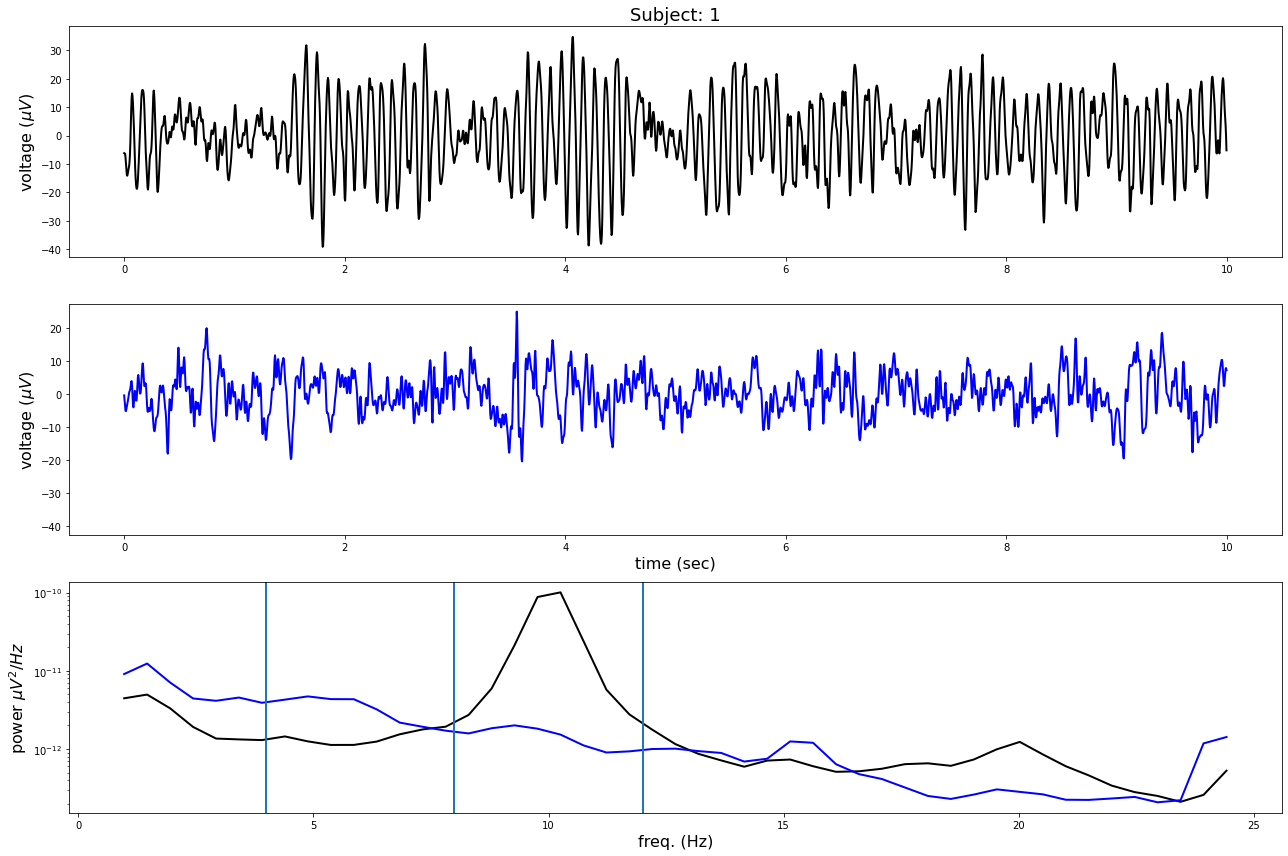

In [11]:
# run this code cell several times to inspect random 10 sec EEG snippets
fig = show_random_data()
plt.show()

# Classifier

https://miro.medium.com/v2/resize:fit:640/format:webp/1*i0o8mjFfCn-uD79-F1Cqkw.png


## Make spectral features

In [12]:
# select frequency bands: True, False
delta = True
theta = True
alpha = True
beta = True

Analyzing sleep stage: N3


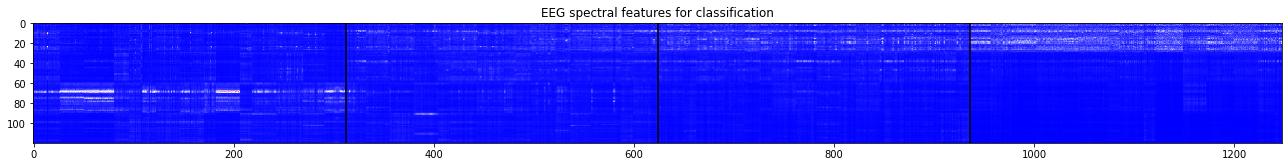

In [13]:
X, y, feature_names = make_features(delta, theta, alpha, beta)

plt.figure(figsize=(18,9))
plt.imshow(X.T, cmap=plt.cm.bwr)
ax = plt.gca()
bounds = 1+np.where(np.diff(y))[0]
for b in bounds:
    ax.axvline(b, color='k')
plt.title("EEG spectral features for classification")
plt.tight_layout()
plt.show()

In [ ]:
#print(feature_names)

## Setup and optimize classifier
- We will split the input (features `X`) and output (targets `y`) variables into two data sets
  - training data (80%)
  - test data (20%) 
- Discuss why this might be helpful?
- Discuss overfitting

In [ ]:
#tmp = np.load("spectral_features.npz")
#X = tmp['X']
#y = tmp['y']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (998, 120)
y_train:  (998,)
X_test:  (250, 120)
y_test:  (250,)


In [15]:
test_params = { 
    'max_features': [5, 15, 25], 
}
# ['sqrt', 3, 10]
#'n_estimators': [100, 200, 300],

fixed_params = {
    'max_depth': 10,   
    'n_estimators': 100,
    'n_jobs': -1,
    'random_state': 42,
}

tuning = GridSearchCV(
    cv = 10,
    estimator = RandomForestClassifier(**fixed_params), 
    n_jobs = -1, 
    param_grid = test_params, 
    scoring = 'accuracy',
)
print("Searching for optimal classifier parameters, be patient...")
tuning.fit(X_train, y_train) # this can take some time...
print("Optimal parameters found: ", tuning.best_params_)
print(f"Best score obtained on training data: {tuning.best_score_:.3f}")
clf_opt = tuning.best_estimator_

Searching for optimal classifier parameters, be patient...
Optimal parameters found:  {'max_features': 15}
Best score obtained on training data: 0.871


- Is there anything concerning about the optimal classifier parameters found?
- How would you address this problem?

## Analyze the optimized classifier

In [16]:
test_score = clf_opt.score(X_test, y_test)
print("Accuracy on test data: ", test_score)

Accuracy on test data:  0.848


- Is the score on test data different from the training data?
- Compare with other groups, is there a systematic difference? Explain the results!

In [17]:
# save the model to disk
f_clf_opt = f"./RFC_opt.pkl"
print(f"Optimized classifier saved as: {f_clf_opt:s}")
with open(f_clf_opt, 'wb') as fp:
    pickle.dump(clf_opt, fp)

Optimized classifier saved as: ./RFC_opt.pkl


Let's ask the classifier which features were the most important for classification!

In [19]:
idx_sort = np.argsort(clf_opt.feature_importances_)[::-1]
feature_importances_sorted = np.array(clf_opt.feature_importances_)[idx_sort]
feature_names_sorted = np.array(feature_names)[idx_sort]
feat_max = 20
for i, fimp in enumerate(feature_importances_sorted[:feat_max]):
    print(f"{i:d}, {feature_names_sorted[i]:s}: {100*fimp:.1f}%")

0, beta_CP6: 4.5%
1, beta_P8: 4.1%
2, beta_AF4: 4.0%
3, alpha_O2: 3.7%
4, delta_O2: 3.6%
5, beta_AFz: 3.5%
6, beta_O1: 3.2%
7, beta_P7: 3.0%
8, delta_O1: 3.0%
9, alpha_P4: 2.4%
10, beta_O2: 2.2%
11, alpha_P8: 2.2%
12, beta_Fz: 2.2%
13, theta_O2: 2.2%
14, alpha_O1: 1.9%
15, beta_CP5: 1.9%
16, delta_AFz: 1.9%
17, beta_T8: 1.9%
18, delta_Fz: 1.9%
19, delta_F3: 1.7%


## Confusion matrix

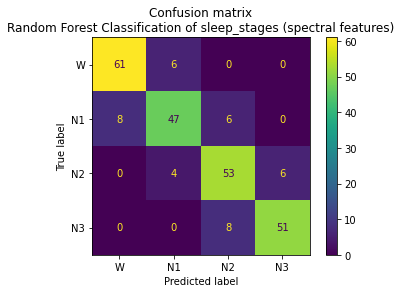

In [20]:
y_predicted = clf_opt.predict(X_test)
conf_mat = confusion_matrix(y_test, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=sleep_stages)
disp.plot()
plt.title(f"Confusion matrix\nRandom Forest Classification of sleep_stages (spectral features)")
plt.show()

- Give a verbal explanation of the confusion matrix, what does it tell you?
- Why is the term _confusion_ used?
- What are common confusions?
- Does the Random Forest Classifier find a similar relationship about which sleep stages are _neighbours_?

In [21]:
acc = clf_opt.score(X_test, y_test)
y_predicted = clf_opt.predict(X_test)
class_report = classification_report(y_test, y_predicted)
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        67
           1       0.82      0.77      0.80        61
           2       0.79      0.84      0.82        63
           3       0.89      0.86      0.88        59

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250



- Look up the definitions of precision and recall (have you heard of sensitivity and specificity?)
- Which sleep stage is the least likely to be confused with another sleep stage?

## Cross-validate classifier

In [23]:
# F1-score cross-validation
n_cv = 10

print(f"\n[+] Cross-validation (N={n_cv:d}) on TRUE labels (wait...)")
folds = StratifiedShuffleSplit(n_splits = n_cv, train_size = 0.8)
scores = []
for idx_train, idx_test in folds.split(X, y):
    X_train, y_train, X_test, y_test = X[idx_train], y[idx_train], X[idx_test], y[idx_test]
    #clf_opt.fit(X_train, y_train)
    y_pred = clf_opt.predict(X_test) # [:, 1]
    f1 = f1_score(y_test, y_pred, average = None, labels = [1])[0]
    scores.append(f1)
print(f"F1-scores: mean={np.mean(scores):.2f}, std={np.std(scores):.2f}")

print(f"\n[+] Cross-validation (N={n_cv:d}) on SHUFFLED labels (wait...)")
y_shuffled = np.random.permutation(y) # test against shuffled labels
folds = StratifiedShuffleSplit(n_splits = n_cv, train_size = 0.8)
scores_shuffled = []
for idx_train, idx_test in folds.split(X, y_shuffled):
    X_train, y_train, X_test, y_test = X[idx_train], y_shuffled[idx_train], X[idx_test], y_shuffled[idx_test]
    #clf_opt.fit(X_train, y_train)
    y_pred = clf_opt.predict(X_test) # [:, 1]
    f1 = f1_score(y_test, y_pred, average = None, labels = [1])[0]
    scores_shuffled.append(f1)
print((f"F1-scores: mean={np.mean(scores_shuffled):.2f}, std={np.std(scores_shuffled):.2f}"))


[+] Cross-validation (N=10) on TRUE labels (wait...)
F1-scores: mean=0.96, std=0.02

[+] Cross-validation (N=10) on SHUFFLED labels (wait...)
F1-scores: mean=0.17, std=0.03


In [24]:
from scipy.stats import mannwhitneyu
t, p_mw = mannwhitneyu(scores, scores_shuffled)
print(f"\n[+] Mann-Whitney U test: p = {p_mw:.4f}")
alpha = 0.05
if ((scores_mean > scores_shuffled_mean) and p_mw < alpha):
    print("Classifier performance IS statistically significant.")
else:
    print("Classifier performance IS NOT statistically significant.")


[+] Mann-Whitney U test: p = 0.0001
Classifier performance IS statistically significant.
